## Install libraries first

Be sure  keras with tensorflow installed
`!conda install -c conda-forge keras`


In [1]:
#!pip install git+https://github.com/qubvel/efficientnet
#!pip install git+https://github.com/qubvel/classification_models.git
#!pip install git+https://github.com/qubvel/segmentation_models
#!pip install -U git+https://github.com/albu/albumentations
#!pip install tta-wrapper

In [2]:
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/s

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3']

## Defining data generator

In [4]:
from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray.reshape((512,512,1))

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

  
def removeAlphaChannel(image):
    return image[:,:,:3]

import albumentations as albu
from albumentations import Resize

class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'../data/val_test', image_folder='img/', mask_folder='masks/', 
                 batch_size=1, image_size=512, nb_y_features=1, 
                 augmentation=None,
                 suffle=True):
        self.image_filenames = listdir_fullpath(os.path.join(root_dir, image_folder))
        self.mask_names = listdir_fullpath(os.path.join(root_dir, mask_folder))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name):
        #return removeAlphaChannel(imread(image_name))/255, rgb2gray(imread(mask_name)).astype(np.int8)
        return (removeAlphaChannel(imread(image_name))/255).astype(np.float32), (imread(mask_name, as_gray=True)<1).astype(np.int8)
 
    def __getitem__(self, index):

            # Generate indexes of the batch
            data_index_min = int(index*self.batch_size)
            data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))

            indexes = self.image_filenames[data_index_min:data_index_max]

            this_batch_size = len(indexes) # The last batch can be smaller than the others

            # Defining dataset
            X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
            y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)

            for i, sample_index in enumerate(indexes):            
                X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], self.mask_names[index * self.batch_size + i])


                # if augmentation is defined, we assume its a train set

                if self.augmentation is not None:

                    # Augmentation code
                    a = self.augmentation(image_size=self.image_size)
                    augmented = a(image=X_sample, mask=y_sample)
                    image_augm = augmented['image']
                    #image_augm = X_sample
                    mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                    #mask_augm = y_sample.reshape(self.image_size, self.image_size, self.nb_y_features)
                    X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                    y[i, ...] = mask_augm

                # if augmentation isnt defined, we assume its a test set. 
                # Because test images can have different sizes we resize it to be divisable by 32
                elif self.augmentation is None and self.batch_size == 1:
                    X_sample, y_sample = self.read_image_mask(self.image_filenames[index * 1 + i], 
                                                          self.mask_names[index * 1 + i])
                    #augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                    #X_sample, y_sample = augmented['image'], augmented['mask']

                    return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                           y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)

            return X, y

## Data augmentation - albumentations

In [5]:
def aug_with_crop(image_size = 512, crop_prob = 1):
    return Compose([
        RandomCrop(width = image_size, height = image_size, p=crop_prob),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.25),
        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)


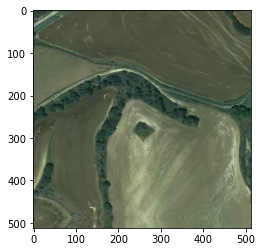

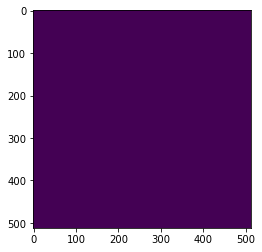

In [6]:
example_generator = DataGeneratorFolder(root_dir = './validation',
                                     image_folder = 'input/', 
                                     mask_folder = 'output/',
                                     batch_size = 5,
                                     nb_y_features = 1, augmentation = aug_with_crop)

Xtest, ytest = example_generator.__getitem__(3)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show()

In [7]:
# setting generators
test_generator = DataGeneratorFolder(root_dir = './validation',
                           image_folder = 'input/',
                           mask_folder = 'output/',
                                   batch_size=1,
                                   nb_y_features = 1)

train_generator = DataGeneratorFolder(root_dir = './training', 
                                      image_folder = 'input/', 
                                      mask_folder = 'output/', 
                                      batch_size=5,
                                      image_size=512, augmentation = aug_with_crop,
                                      nb_y_features = 1)

## Callbacks

In [8]:
#!mkdir weights

In [9]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("./weights/unetinception.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =10)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0, write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

In [10]:
from segmentation_models import Linknet
from keras.optimizers import Adam
import segmentation_models as sm
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss

def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(13,6))
    ax_loss.plot(history.epoch, history.history["loss"], label="Training loss", color="blue")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss", color="red")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou", color="blue")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou", color="red")
    ax_acc.legend()

Segmentation Models: using `keras` framework.


In [11]:
model = Linknet(backbone_name = 'efficientnetb5', encoder_weights='imagenet', encoder_freeze = False)
model.compile(optimizer = Adam(),loss=bce_jaccard_loss, metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [12]:
history = model.fit_generator(train_generator, shuffle = True, epochs = 200, workers = 4, 
                              use_multiprocessing = True, validation_data = test_generator, 
                              verbose = 1, callbacks=callbacks)

Epoch 1/200


/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17142/17143 [============================>.] - ETA: 0s - loss: 0.5989 - iou_score: 0.5176 - f1-score: 0.6473

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10642s 621ms/step - loss: 0.5989 - iou_score: 0.5176 - f1-score: 0.6474 - val_loss: 0.6484 - val_iou_score: 0.4359 - val_f1-score: 0.5579
Epoch 2/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.5161 - iou_score: 0.5742 - f1-score: 0.7025

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10366s 605ms/step - loss: 0.5161 - iou_score: 0.5742 - f1-score: 0.7026 - val_loss: 0.6088 - val_iou_score: 0.4680 - val_f1-score: 0.5898
Epoch 3/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4955 - iou_score: 0.5891 - f1-score: 0.7160

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10377s 605ms/step - loss: 0.4955 - iou_score: 0.5891 - f1-score: 0.7160 - val_loss: 0.6556 - val_iou_score: 0.4450 - val_f1-score: 0.5706
Epoch 4/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4818 - iou_score: 0.5980 - f1-score: 0.7241

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10344s 603ms/step - loss: 0.4818 - iou_score: 0.5980 - f1-score: 0.7241 - val_loss: 0.6226 - val_iou_score: 0.4666 - val_f1-score: 0.5895
Epoch 5/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4729 - iou_score: 0.6047 - f1-score: 0.7302

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10373s 605ms/step - loss: 0.4730 - iou_score: 0.6047 - f1-score: 0.7302 - val_loss: 0.5876 - val_iou_score: 0.4778 - val_f1-score: 0.5987
Epoch 6/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4655 - iou_score: 0.6100 - f1-score: 0.7350

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10340s 603ms/step - loss: 0.4655 - iou_score: 0.6100 - f1-score: 0.7350 - val_loss: 0.5920 - val_iou_score: 0.4810 - val_f1-score: 0.6037
Epoch 7/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4603 - iou_score: 0.6133 - f1-score: 0.7379

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10355s 604ms/step - loss: 0.4603 - iou_score: 0.6133 - f1-score: 0.7378 - val_loss: 0.6040 - val_iou_score: 0.4816 - val_f1-score: 0.6054
Epoch 8/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4547 - iou_score: 0.6181 - f1-score: 0.7421

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10366s 605ms/step - loss: 0.4547 - iou_score: 0.6181 - f1-score: 0.7421 - val_loss: 0.6401 - val_iou_score: 0.4661 - val_f1-score: 0.5934
Epoch 9/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4526 - iou_score: 0.6196 - f1-score: 0.7433

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10360s 604ms/step - loss: 0.4526 - iou_score: 0.6196 - f1-score: 0.7433 - val_loss: 0.5581 - val_iou_score: 0.5044 - val_f1-score: 0.6196
Epoch 10/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4491 - iou_score: 0.6223 - f1-score: 0.7456

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10381s 606ms/step - loss: 0.4491 - iou_score: 0.6223 - f1-score: 0.7456 - val_loss: 0.7293 - val_iou_score: 0.4592 - val_f1-score: 0.5812

Epoch 00010: val_iou_score improved from -inf to 0.45918, saving model to ./weights/unetinception.h5
Epoch 11/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4442 - iou_score: 0.6261 - f1-score: 0.7489

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10401s 607ms/step - loss: 0.4442 - iou_score: 0.6261 - f1-score: 0.7489 - val_loss: 0.8286 - val_iou_score: 0.4593 - val_f1-score: 0.5754
Epoch 12/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4413 - iou_score: 0.6286 - f1-score: 0.7513

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10394s 606ms/step - loss: 0.4413 - iou_score: 0.6286 - f1-score: 0.7513 - val_loss: 0.7387 - val_iou_score: 0.4632 - val_f1-score: 0.5814
Epoch 13/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4387 - iou_score: 0.6298 - f1-score: 0.7522

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10377s 605ms/step - loss: 0.4387 - iou_score: 0.6298 - f1-score: 0.7522 - val_loss: 0.7076 - val_iou_score: 0.4687 - val_f1-score: 0.5897
Epoch 14/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4383 - iou_score: 0.6301 - f1-score: 0.7527

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10381s 606ms/step - loss: 0.4383 - iou_score: 0.6301 - f1-score: 0.7527 - val_loss: 0.7949 - val_iou_score: 0.4588 - val_f1-score: 0.5753
Epoch 15/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4362 - iou_score: 0.6324 - f1-score: 0.7546

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10397s 606ms/step - loss: 0.4362 - iou_score: 0.6324 - f1-score: 0.7546 - val_loss: 0.7692 - val_iou_score: 0.4646 - val_f1-score: 0.5842
Epoch 16/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4343 - iou_score: 0.6338 - f1-score: 0.7556

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10386s 606ms/step - loss: 0.4343 - iou_score: 0.6338 - f1-score: 0.7556 - val_loss: 0.5760 - val_iou_score: 0.5046 - val_f1-score: 0.6230
Epoch 17/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4339 - iou_score: 0.6333 - f1-score: 0.7554

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10389s 606ms/step - loss: 0.4339 - iou_score: 0.6333 - f1-score: 0.7553 - val_loss: 0.5934 - val_iou_score: 0.4849 - val_f1-score: 0.6036
Epoch 18/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4313 - iou_score: 0.6357 - f1-score: 0.7574

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10365s 605ms/step - loss: 0.4313 - iou_score: 0.6357 - f1-score: 0.7574 - val_loss: 0.5707 - val_iou_score: 0.5138 - val_f1-score: 0.6322
Epoch 19/200
17142/17143 [============================>.] - ETA: 0s - loss: 0.4262 - iou_score: 0.6397 - f1-score: 0.7607

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead", FutureWarning)
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:152: FutureWarning: IAAEmboss is deprecated. Please use Emboss instead
  warnings.warn("IAAEmboss is deprecated. Please use Emboss instead",

17143/17143 [==============================] - 10393s 606ms/step - loss: 0.4262 - iou_score: 0.6397 - f1-score: 0.7607 - val_loss: 0.8860 - val_iou_score: 0.4480 - val_f1-score: 0.5659

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00019: early stopping


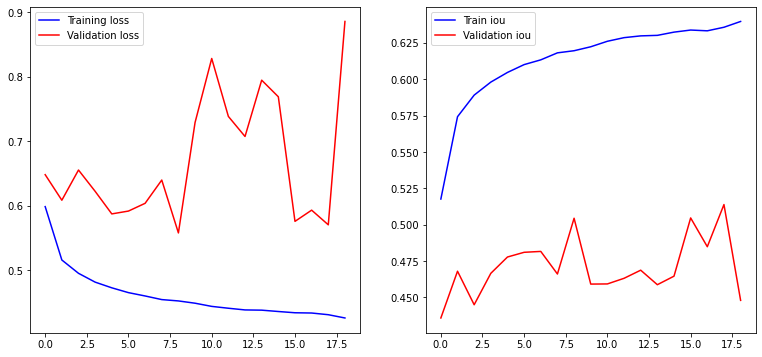

In [13]:
plot_training_history(history)

## Inference and model quality  check

#### Single image

In [14]:
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def plot_mask_gt_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Blues")
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[2].imshow(img)
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

# to get single image and prediction quality
Xtest, y_test  = test_generator.__getitem__(0)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(512, 512)
print('IOU', iou_metric(y_test[0].reshape(512, 512), predicted)) 

IOU [[0.66788767]]


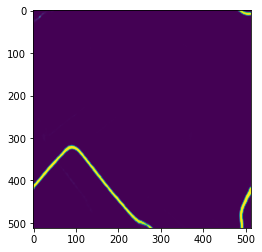

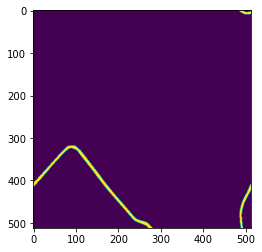

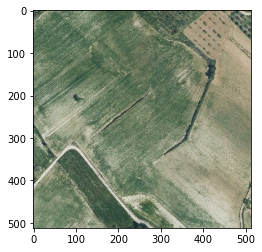

In [15]:
plt.imshow(predicted)
plt.show()
plt.imshow(y_test[0].reshape((512,512)))
plt.show()
plt.imshow(Xtest[0])
plt.show()

## Overall quality

In [16]:
scores = model.evaluate_generator(test_generator)
metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))  

Loss: 0.88595
mean iou_score: 0.448
mean f1-score: 0.5659


In [17]:
model.save("models1/Linknet-EfficientNetb5.h5")